### US Stock Fundamentals From Morningstar  ###

In [49]:
import pandas as pd
import urllib.request as r
import sys
import matplotlib.pyplot as plt
import numpy as np
import quandl 

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [48]:
def get_data(company):

    api_fundamentals = 'http://financials.morningstar.com/ajax/exportKR2CSV.html?t='+company
    api_income = 'http://financials.morningstar.com/ajax/ReportProcess4CSV.html?t='+company+'&reportType=is&period=12&dataType=A&order=asc&columnYear=5&number=3'
    api_financials = 'http://financials.morningstar.com/ajax/ReportProcess4CSV.html?t='+company+'&reportType=bs&period=12&dataType=A&order=asc&columnYear=5&number=3'
    api_curr_val = 'http://financials.morningstar.com/valuate/current-valuation-list.action?&t='+company+'&region=usa&culture=en-US&cur=&adsFlag=true&_=1490717022553'
    api_fwd_val = 'http://financials.morningstar.com/valuate/forward-valuation-list.action?&t='+company+'&region=usa&culture=en-US&cur=&adsFlag=true&_=1490717022554'
    
    # Get Price History
    data_price = quandl.get("WIKI/"+company, start_date="2008-10-01", end_date="2018-01-01", collapse="annual")['Adj. Close']

    # Get Fundamentals Ratios
    request = r.Request(api_fundamentals)
    response = r.urlopen(request)
    txt = StringIO(response.read().decode('utf-8'))
    data_fundamentals = pd.read_csv(txt, sep=",", skiprows=2)
    
    # Get Income Statement
    request = r.Request(api_income)
    response = r.urlopen(request)
    txt = StringIO(response.read().decode('utf-8'))
    data_income = pd.read_csv(txt, sep=",")
    
    # Get Cash Financials 
    request = r.Request(api_financials)
    response = r.urlopen(request)
    txt = StringIO(response.read().decode('utf-8'))
    data_financials = pd.read_csv(txt, sep=",")
    
    # Get PEG Ratio
    request = r.Request(api_fwd_val)
    response = r.urlopen(request)
    string = response.read().decode('utf-8')
    start = string.find('PEG Ratio') + 45
    end = start + 3
    peg_ratio = float(string[start:end])
    
    return data_fundamentals, data_income, data_financials, data_price, peg_ratio
    

In [51]:
import string 

class stock():
    
    def __init__(self, fundamentals, income, financials, price, peg_ratio, company):
        self.name = company
        self.data = fundamentals
        self.data_i = income
        self.data_fin = financials
        self.data_price = price
        
        self.pct_change_eps = None 
        self.eps_cagr = None
        self.gm = None
        self.gm_growth = None
        self.roe = None
        self.roe_growth = None
        self.ltd_ni = None
        self.ltd_ni_growth = None
        self.d2e = None
        self.d2e_growth = None
        self.ev_ebit = None
        self.ev_ebit_growth = None
        self.peg = peg_ratio

    def earnings_per_share(self):
        eps = self.data.iloc[5].iloc[1:-1].tolist()
        date = np.array(list(self.data)[1:-1])

        x = np.arange(len(eps))
        y = [float(e) for e in eps]

        plt.figure(figsize=(10, 5))
        plt.xticks(x, date)
        plt.title('Earnings Per Share Growth', fontsize=16)
        plt.ylabel('EPS', fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.plot(x, y)
        plt.show()
        self.pct_change_eps = self.metric_growth(y)
        
                
    def metric_growth(self, m):
        print('Max: ' + str(max(m)))
        print('Min: ' + str(min(m)))
        print('Mean: ' + str(np.mean(m)))
        pct_change = (m[-1] - m[0]) / m[0] * 100
        print('pct_change: ' + str(pct_change) + '%')
    
        return pct_change
    
    
    def eps_compounded_annual_growth_rate(self):
        eps = self.data.iloc[5].iloc[-6:-1].tolist() 
        eps = [float(e) for e in eps]
        self.eps_cagr = ((eps[-1]/eps[0])**(1/5) - 1) * 100
            
            
    def gross_margin(self):
        gm = self.data.iloc[19].iloc[-6:-1].tolist()
        date = np.array(list(self.data)[-6:-1])

        x = np.arange(len(gm))
        y = [float(g) for g in gm]

        plt.figure(figsize=(10, 5))
        plt.xticks(x, date)
        plt.title('Gross Margin Growth', fontsize=16)
        plt.ylabel('GM', fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.plot(x, y)
        plt.show()
        
        self.gm = y[-1]
        self.gm_growth = self.metric_growth(y)
        
        
    def return_on_equity(self):
        roe = self.data.iloc[32].iloc[-6:-1].tolist()
        date = np.array(list(self.data)[-6:-1])

        x = np.arange(len(roe))
        y = [float(r) for r in roe]

        plt.figure(figsize=(10, 5))
        plt.xticks(x, date)
        plt.title('Return On Equity Growth', fontsize=16)
        plt.ylabel('ROE', fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.plot(x, y)
        plt.show()
        
        self.roe = y[-1]
        self.roe_growth = self.metric_growth(y)
        
    
    def long_term_debt_over_net_income(self):
        ltd = self.data.iloc[83].iloc[-6:-1].tolist() 
        ltd = [float(l) for l in ltd]
        
        ni = self.data.iloc[63].iloc[-6:-1].tolist() 
        ni = [float(n) for n in ni]
        
        date = np.array(list(self.data)[-6:-1])
        
        y = np.array(ltd) / np.array(ni)
        print(ltd)
        print(ni)
        print(y)
        x = np.arange(len(y))

        plt.figure(figsize=(10, 5))
        plt.xticks(x, date)
        plt.title('Long Term Debt / Net Income', fontsize=16)
        plt.ylabel('LTD/NI', fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.plot(x, y)
        plt.show()
        
        self.ltd_ni = y[-1]
        self.ltd_ni_growth = self.metric_growth(y)
        

    def debt_to_equity(self):
        d2e = self.data.iloc[90].iloc[-6:-1].tolist()
        date = np.array(list(self.data)[-6:-1])

        x = np.arange(len(d2e))
        y = [float(d) for d in d2e]
        y = np.nan_to_num(y)

        plt.figure(figsize=(10, 5))
        plt.xticks(x, date)
        plt.title('Return On Equity Growth', fontsize=16)
        plt.ylabel('ROE', fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.plot(x, y)
        plt.show()
        
        self.d2e = y[-1]
        self.d2e_growth = self.metric_growth(y)
        
    
    def ev_over_ebit(self):
                
        shares_outstanding = np.array([''.join(c for c in s if c not in string.punctuation) for s in self.data.iloc[8].iloc[-6:-1].tolist()])      
        shares_outstanding = np.array([float(l) for l in shares_outstanding])        
        stock_price = np.array([float(l) for l in self.data_price.iloc[-6:-1].tolist()])
        long_term_debt = np.array([float(l) for l in self.data.iloc[83].iloc[-6:-1].tolist()])
        short_term_debt = np.array([float(l) for l in self.data.iloc[76].iloc[-6:-1].tolist()])
        short_term_debt = np.nan_to_num(short_term_debt)
        cash_and_cash = np.array([float(l) for l in list(self.data.iloc[66].iloc[-6:-1].tolist())])
        operating_income = np.array([float(l) for l in list(self.data_i.index.tolist()[9])[1:]])
        other_income = np.array([float(l) for l in list(self.data_i.index.tolist()[11])[1:]])
            
        enterprise_value = (shares_outstanding * stock_price) + (long_term_debt + short_term_debt) - cash_and_cash
        earnings_before_interest_tax = operating_income + other_income
        ev_over_ebit = enterprise_value / earnings_before_interest_tax
        
        date = np.array(list(self.data)[-6:-1])

        x = np.arange(len(ev_over_ebit))
        y = [float(d) for d in ev_over_ebit]
        y = np.nan_to_num(y)

        plt.figure(figsize=(10, 5))
        plt.xticks(x, date)
        plt.title('EV/EBIT Growth', fontsize=16)
        plt.ylabel('EV/EBIT', fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.plot(x, y)
        plt.show()
        
        print(y)
        
        self.ev_ebit = y[-1]
        self.ev_ebit_growth = self.metric_growth(y)

    
    def evaluate(self):
        
        # All Graphs and Key Figures
        self.earnings_per_share()
        self.eps_compounded_annual_growth_rate()
        self.gross_margin()
        self.return_on_equity()
        self.long_term_debt_over_net_income()
        self.debt_to_equity()
        self.ev_over_ebit()
        
        self.summary()
        
    def summary(self):
        print(' ')
        print(' ############################################################## ')
        print('                  ' + self.name + ' Summary Evaluation')
        print(' ############################################################## ')
        print(' ')
        
        # Evaluation and Summary Of Key Ratios
        if self.pct_change_eps > 0:
            print(' ### Healthy EPS Over Past 10 Years: ' + str(self.pct_change_eps) + '% ###')
        else:
            print(' ### Unhealthy EPS Over Past 10 Years: ' + str(self.pct_change_eps) + '% ###')
            
        if self.eps_cagr > 0:
            print(' ### Healthy EPS-CAGR Over Past 5 Years: ' + str(self.eps_cagr) + '% ###')
        else:
            print(' ### Unhealthy EPS-CAGR Over Past 5 Years: ' + str(self.eps_cagr) + '% ###')
            
        if self.gm >= 40 and self.gm_growth > 0:
            print(' ### Healthy Gross Margin Over Past 5 Years: ' + str(self.gm) + '% increasing at' + str(self.gm_growth) + '% ###')
        elif self.gm >= 40 and self.gm_growth < 0:
            print(' ### Healthy Gross Margin Over Past 5 Years: ' + str(self.gm) + '% decreasing at' + str(self.gm_growth) + '% ###')
        elif self.gm < 40 and self.gm_growth > 0:
            print(' ### Unhealthy Gross Margin Over Past 5 Years: ' + str(self.gm) + '% increasing at' + str(self.gm_growth) + '% ###')
        else:
            print(' ### Unhealthy Gross Margin Over Past 5 Years: ' + str(self.gm) + '% decreasing at' + str(self.gm_growth) + '% ###')

        
        if self.roe >= 15 and self.roe_growth > 0:
            print(' ### Healthy ROE over Past 5 Years: ' + str(self.roe) + '% increasing at ' + str(self.roe_growth) + '% ###')
        elif self.roe >= 15 and self.roe_growth < 0:
            print(' ### Healthy ROE over Past 5 Years: ' + str(self.roe) + '% decreasing at ' + str(self.roe_growth) + '% ###')
        elif self.roe < 15 and self.roe_growth > 0:
            print(' ### Unhealthy ROE over Past 5 Years: ' + str(self.roe) + '% increasing at ' + str(self.roe_growth) + '% ###')
        else:
            print(' ### Unhealthy ROE over Past 5 Years: ' + str(self.roe) + '% decreasing at ' + str(self.roe_growth) + '% ###')
        
        
        if self.ltd_ni <= 5 and self.ltd_ni_growth > 0:
            print(' ### Healthy LTD/NI over Past 5 Years: ' + str(self.ltd_ni) + ' increasing at ' + str(self.ltd_ni_growth) + '% ###')
        elif self.ltd_ni <= 5 and self.ltd_ni_growth < 0:
            print(' ### Healthy LTD/NI over Past 5 Years: ' + str(self.ltd_ni) + ' decreasing at ' + str(self.ltd_ni_growth) + '% ###')
        elif self.ltd_ni > 5 and self.ltd_ni_growth > 0:
            print(' ### Unhealthy LTD/NI over Past 5 Years: ' + str(self.ltd_ni) + ' increasing at ' + str(self.ltd_ni_growth) + '% ###')
        else:
            print(' ### Unhealthy LTD/NI over Past 5 Years: ' + str(self.ltd_ni) + ' decreasing at ' + str(self.ltd_ni_growth) + '% ###')
        
        if self.d2e <= 0.5 and self.ltd_ni_growth > 0:
            print(' ### Healthy D/E over Past 5 Years: ' + str(self.d2e) + ' increasing at ' + str(self.d2e_growth) + '% ###')
        elif self.d2e <= 0.5  and self.d2e_growth < 0:
            print(' ### Healthy D/E over Past 5 Years: ' + str(self.d2e) + ' decreasing at ' + str(self.d2e_growth) + '% ###')
        elif self.d2e > 0.5 and self.d2e_growth > 0:
            print(' ### Unhealthy D/E over Past 5 Years: ' + str(self.d2e) + ' increasing at ' + str(self.d2e_growth) + '% ###')
        else:
            print(' ### Unhealthy D/E over Past 5 Years: ' + str(self.d2e) + ' decreasing at ' + str(self.d2e_growth) + '% ###')
        
        if self.ev_ebit <= 1 and self.ev_ebit_growth > 0:
            print(' ### Undervalued EV/EBIT over Past 5 Years: ' + str(self.ev_ebit) + ' increasing at ' + str(self.ev_ebit_growth) + '% ###')
        elif self.ev_ebit <= 1 and self.ev_ebit_growth < 0:
            print(' ### Undervalued EV/EBIT over Past 5 Years: ' + str(self.ev_ebit) + ' decreasing at ' + str(self.ev_ebit_growth) + '% ###')
        elif self.ev_ebit > 1 and self.ev_ebit_growth > 0:
            print(' ### Overvalued EV/EBIT over Past 5 Years: ' + str(self.ev_ebit) + ' increasing at ' + str(self.ev_ebit_growth) + '% ###')
        else:
            print(' ### Overvalued EV/EBIT over Past 5 Years: ' + str(self.ev_ebit) + ' decreasing at ' + str(self.ev_ebit_growth) + '% ###')
            
        if self.peg <= 1:
            print(' ### Undervalued @ PEG Ratio ' + str(self.peg) + ' ###')
        else:
            print(' ### Overvalued @ PEG Ratio ' + str(self.peg) + ' ###')
        

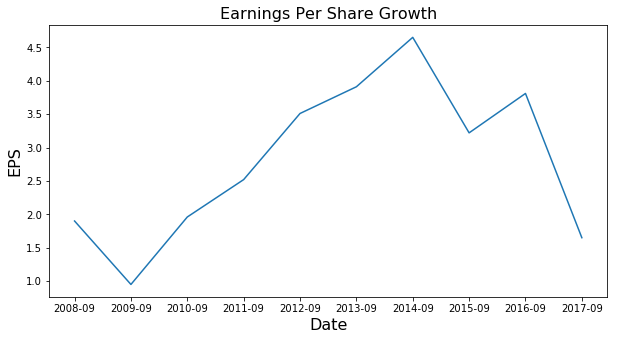

Max: 4.65
Min: 0.95
Mean: 2.808
pct_change: -13.157894736842104%


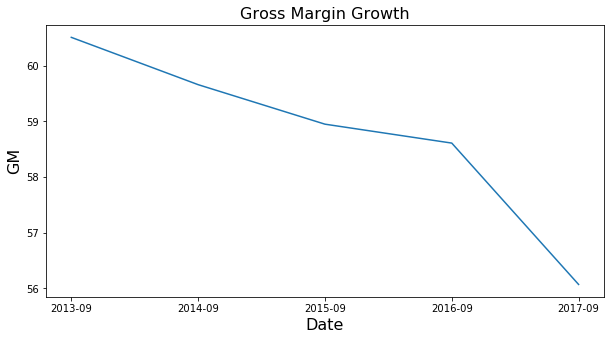

Max: 60.51
Min: 56.07
Mean: 58.76
pct_change: -7.337630143777885%


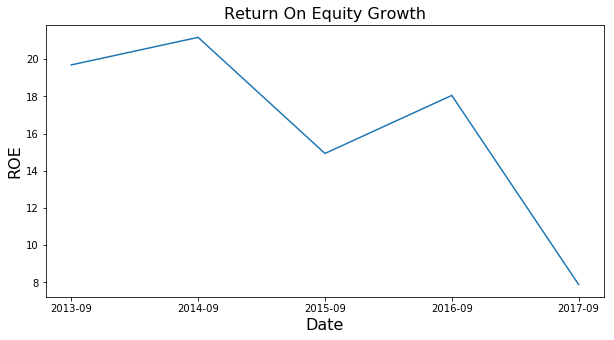

Max: 21.17
Min: 7.89
Mean: 16.346
pct_change: -59.92889791772473%
[20.71, 19.36, 38.14, 39.31, 53.05]
[1.13, 0.97, 0.86, 1.2, 1.62]
[ 18.32743363  19.95876289  44.34883721  32.75833333  32.74691358]


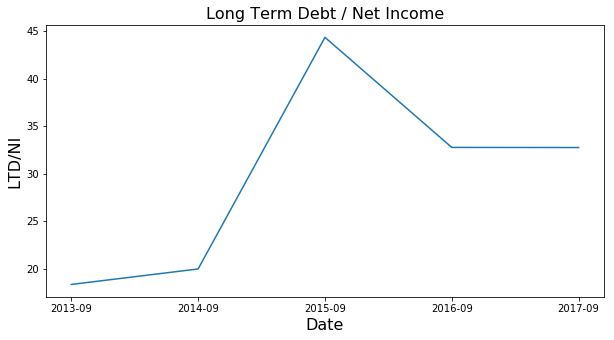

Max: 44.3488372093
Min: 18.3274336283
Mean: 29.6280561276
pct_change: 78.6770272606%


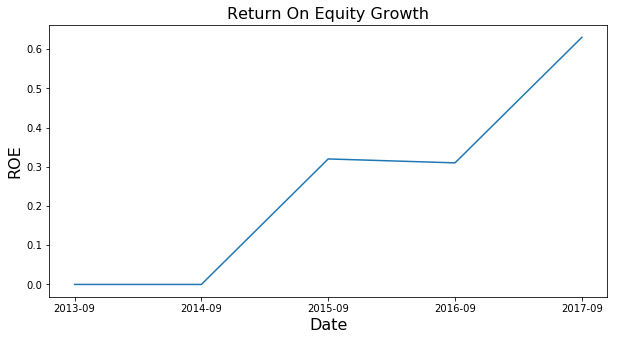

Max: 0.63
Min: 0.0
Mean: 0.252
pct_change: inf%


/Users/Dylan/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


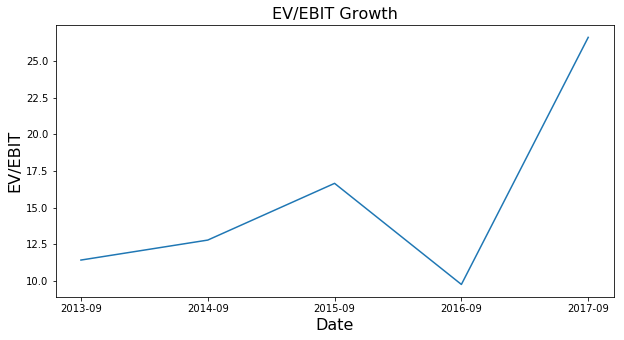

[ 11.41998079  12.78252284  16.64994506   9.7575676   26.60439951]
Max: 26.604399512
Min: 9.75756759851
Mean: 15.44288316
pct_change: 132.963610104%
 
 ############################################################## 
                  QCOM Summary Evaluation
 ############################################################## 
 
 ### Unhealthy EPS Over Past 10 Years: -13.157894736842104% ###
 ### Unhealthy EPS-CAGR Over Past 5 Years: -15.848582217553576% ###
 ### Healthy Gross Margin Over Past 5 Years: 56.07% decreasing at-7.337630143777885% ###
 ### Unhealthy ROE over Past 5 Years: 7.89% decreasing at -59.92889791772473% ###
 ### Unhealthy LTD/NI over Past 5 Years: 32.7469135802 increasing at 78.6770272606% ###
 ### Unhealthy D/E over Past 5 Years: 0.63 increasing at inf% ###
 ### Overvalued EV/EBIT over Past 5 Years: 26.604399512 increasing at 132.963610104% ###
 ### Overvalued @ PEG Ratio 1.9 ###


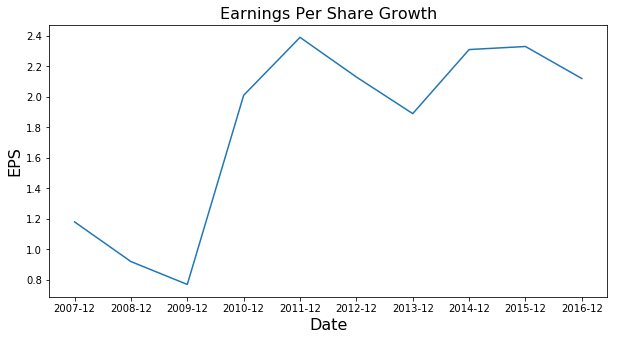

Max: 2.39
Min: 0.77
Mean: 1.805
pct_change: 79.66101694915257%


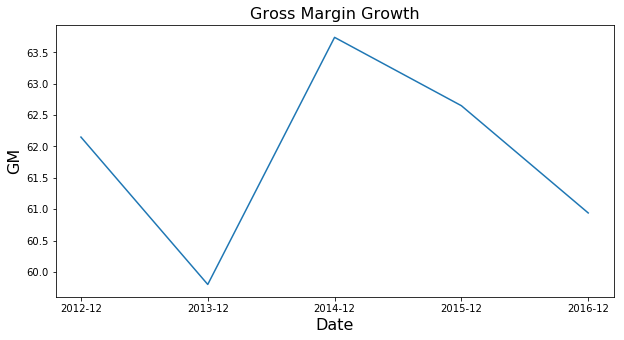

Max: 63.74
Min: 59.8
Mean: 61.856
pct_change: -1.9469026548672579%


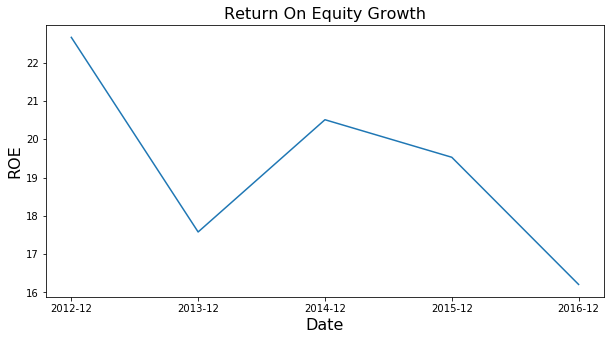

Max: 22.66
Min: 16.21
Mean: 19.298
pct_change: -28.464254192409527%
[39.3, 36.92, 39.25, 40.73, 41.56]
[0.64, 1.04, 0.87, 1.01, 1.18]
[ 61.40625     35.5         45.11494253  40.32673267  35.22033898]


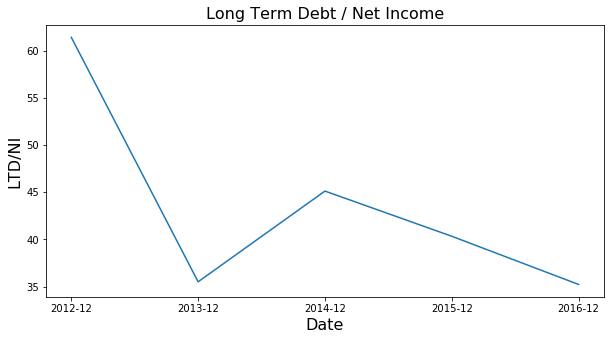

Max: 61.40625
Min: 35.2203389831
Mean: 43.513652837
pct_change: -42.6437227757%


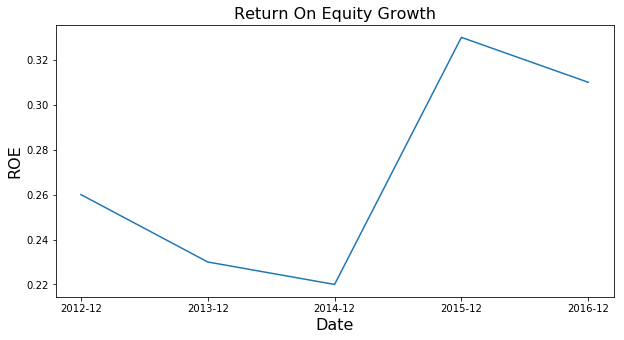

Max: 0.33
Min: 0.22
Mean: 0.27
pct_change: 19.2307692308%


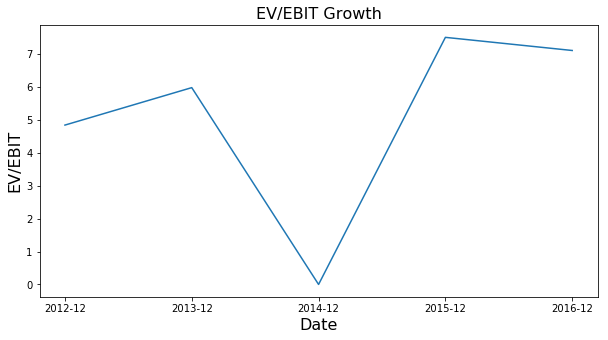

[ 4.84335499  5.98155345  0.          7.50968006  7.11062508]
Max: 7.50968006283
Min: 0.0
Mean: 5.08904271862
pct_change: 46.8119741564%
 
 ############################################################## 
                  INTC Summary Evaluation
 ############################################################## 
 
 ### Healthy EPS Over Past 10 Years: 79.66101694915257% ###
 ### Unhealthy EPS-CAGR Over Past 5 Years: -0.09407354381925082% ###
 ### Healthy Gross Margin Over Past 5 Years: 60.94% decreasing at-1.9469026548672579% ###
 ### Healthy ROE over Past 5 Years: 16.21% decreasing at -28.464254192409527% ###
 ### Unhealthy LTD/NI over Past 5 Years: 35.2203389831 decreasing at -42.6437227757% ###
 ### Unhealthy D/E over Past 5 Years: 0.31 decreasing at 19.2307692308% ###
 ### Overvalued EV/EBIT over Past 5 Years: 7.11062508337 increasing at 46.8119741564% ###
 ### Overvalued @ PEG Ratio 2.7 ###


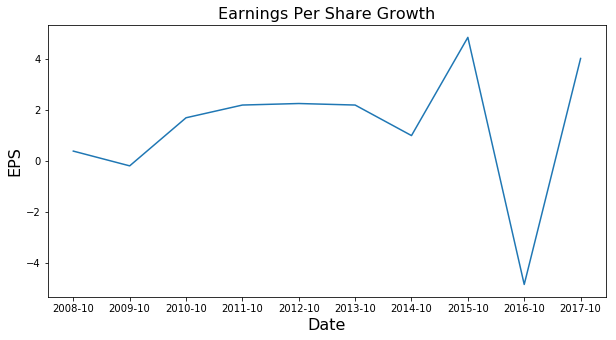

Max: 4.85
Min: -4.86
Mean: 1.35
pct_change: 957.8947368421051%


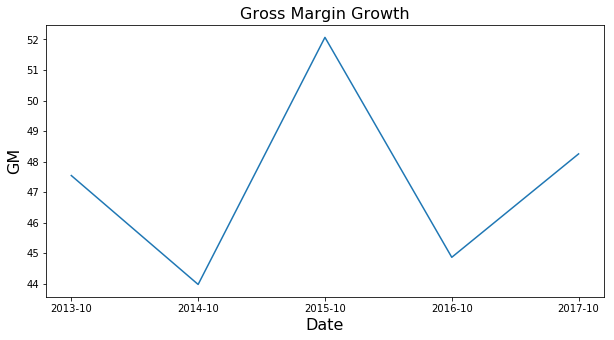

Max: 52.07
Min: 43.97
Mean: 47.338
pct_change: 1.4934791754312176%


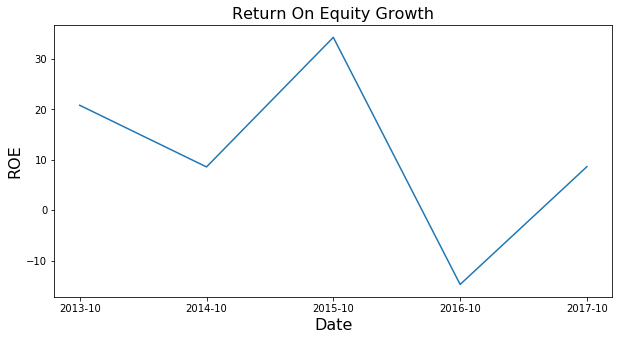

Max: 34.28
Min: -14.73
Mean: 11.516
pct_change: -58.4814992791927%
[15.49, 69.09, 55.49, 62.19, 62.72]
[0.88, 2.91, 1.26, -1.55, 3.24]
[ 17.60227273  23.74226804  44.03968254 -40.12258065  19.35802469]


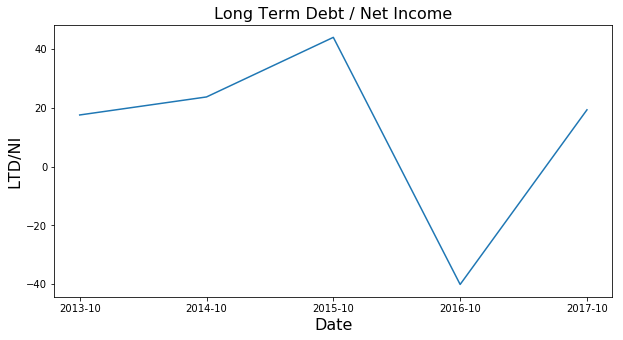

Max: 44.0396825397
Min: -40.1225806452
Mean: 12.9239334709
pct_change: 9.97457539312%


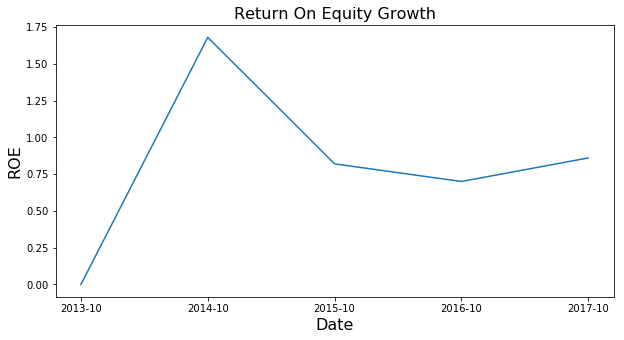

Max: 1.68
Min: 0.0
Mean: 0.812
pct_change: inf%


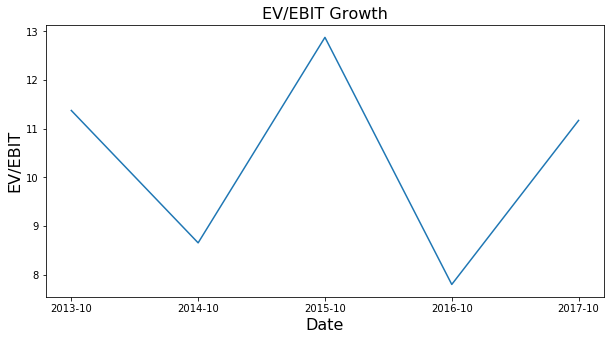

[ 11.37538625   8.65784571  12.87651911   7.80384902  11.17121674]
Max: 12.8765191085
Min: 7.80384902403
Mean: 10.376963367
pct_change: -1.79483584628%
 
 ############################################################## 
                  AVGO Summary Evaluation
 ############################################################## 
 
 ### Healthy EPS Over Past 10 Years: 957.8947368421051% ###
 ### Healthy EPS-CAGR Over Past 5 Years: 12.916234673483551% ###
 ### Healthy Gross Margin Over Past 5 Years: 48.25% increasing at1.4934791754312176% ###
 ### Unhealthy ROE over Past 5 Years: 8.64% decreasing at -58.4814992791927% ###
 ### Unhealthy LTD/NI over Past 5 Years: 19.3580246914 increasing at 9.97457539312% ###
 ### Unhealthy D/E over Past 5 Years: 0.86 increasing at inf% ###
 ### Overvalued EV/EBIT over Past 5 Years: 11.1712167397 decreasing at -1.79483584628% ###
 ### Undervalued @ PEG Ratio 0.9 ###


In [52]:
companies = ['QCOM', 'INTC', 'AVGO']
for company in companies:
    data_fundamentals, data_income, data_financials, data_price, peg_ratio = get_data(company)
    c = stock(data_fundamentals, data_income, data_financials, data_price, peg_ratio, company)
    c.evaluate()

In [ ]:
data_financials.index.tolist()

In [ ]:
'''
1) What is the company's major business model and competitive advantage? (Brand, Low-Cost, Patents, Pricing Power, Licenses, Networks)
2) Is it consistently profitable & healthy? (+tive EPS)/10 years and (+tive EPS-CAGR)/5 years, gross margin > 40%, RoE > 15%, long-term-debt / net-income < 5, D/E ratio < 50%?
3) Is the management competent & trustworthy? (Proxy Statements)
4) Is it valued correctly with Price (P/E TTM) and Enterprise (EV/EBIT) Multiples < 1) its past 5 years & 2) the mean/median of its 2 biggest competitors? If possible, plot out against min avg and max of comparable company’s multiples to get a feel of undervaluation.
5) Is it at a cheap price with PEG ratio < 1? Have you weighed the excellence of the business with the risks associated with it?

'''

### US Stock Prices From Quandl  ###

In [ ]:
import quandl 

qcom_price = quandl.get("WIKI/QCOM", start_date="2008-10-01", end_date="2018-01-01", collapse="annual")
qcom_price['Adj. Close']

# Adj Close - the day's closing price, slightly adjusted to include any actions that occurred at any time before the next day’s open. 

### US Stocks (Limited) Fundamentals From Quandl  ###

In [ ]:
#api = 'https://www.quandl.com/api/v3/datatables/SHARADAR/SF1.csv?ticker=AAPL&qopts.columns=ticker,dimension,datekey,revenue&api_key=LpHizpwutLkYb1RFXME3'
# api = 'https://www.quandl.com/api/v3/datatables/ZACKS/FR.csv?api_key=LpHizpwutLkYb1RFXME3'

import quandl

auth_tok = "LpHizpwutLkYb1RFXME3"
ratios = []
ratio_screener = []
companies = ['AAPL']

full_data = quandl.get_table('ZACKS/FE', per_type='A')
full_data

In [ ]:
'''

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data_fundamentals)
    
request = r.Request(api_income)
response = r.urlopen(request)
txt = StringIO(response.read().decode('utf-8'))

data_income = pd.read_csv(txt, sep=",")
data_income.head()

request = r.Request(api_financials)
response = r.urlopen(request)
txt = StringIO(response.read().decode('utf-8'))
data_financials = pd.read_csv(txt, sep=",")
data_financials.head()

request = r.Request(api_fwd_val)
response = r.urlopen(request)
string = response.read().decode('utf-8')

start = string.find('PEG Ratio') + 45
end = start + 3
peg_ratio = float(string[start:end])
print(peg_ratio)

import quandl 

data_price = quandl.get("WIKI/QCOM", start_date="2008-10-01", end_date="2018-01-01", collapse="annual")['Adj. Close']
data_price

'''


In [ ]:
api_price = 'https://www.quandl.com/api/v3/datasets/EOD/QCOM.csv?api_key=LpHizpwutLkYb1RFXME3'

request = r.Request(api_price)
response = r.urlopen(request)
txt = StringIO(response.read().decode('utf-8'))

data = pd.read_csv(txt, sep=",")
data[:10]